<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Importing Libraries</p>

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# !pip install torch-snippets==0.495
from torch_snippets import *


<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Dataset</p>

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class LevirSegmentationDataset(Dataset):
    def __init__(self, root_dir, mode='train', img_transform=None, mask_transform=None):
        self.mode = mode
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        self.img_dir = os.path.join(root_dir, mode, 'B')
        self.mask_dir = os.path.join(root_dir, mode, 'label')
        self.images = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(os.path.join(self.img_dir, img_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert('L')
        
        # Применяем РАЗНЫЕ трансформации
        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Маска в диапазон [0, 1]
        mask = mask / 255.0
        return img, mask

# --- Определяем трансформации ---

# Для изображений: Нормализация полезна
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Для масок: Нормализация НЕ НУЖНА! Только геометрия.
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Путь к данным (укажите свой)
DATA_PATH = r'E:\rabota\photogrammetry\LEVIR CD' 

# Инициализация датасетов
train_dataset = LevirSegmentationDataset(DATA_PATH, mode='train', 
                                         img_transform=img_transform, 
                                         mask_transform=mask_transform)
val_dataset = LevirSegmentationDataset(DATA_PATH, mode='val', 
                                       img_transform=img_transform, 
                                       mask_transform=mask_transform)

tr_dl = DataLoader(train_dataset, batch_size=8, shuffle=True)
tst_dl = DataLoader(val_dataset, batch_size=8, shuffle=False)

<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Model</p>

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

# --- 1. КОМПОНЕНТЫ МОДЕЛИ (Ваши классы без изменений) ---

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, base_filters=64):
        super(UNet, self).__init__()
        
        self.enc1 = ConvBlock(in_channels, base_filters)
        self.enc2 = ConvBlock(base_filters, base_filters * 2)
        self.enc3 = ConvBlock(base_filters * 2, base_filters * 4)
        self.enc4 = ConvBlock(base_filters * 4, base_filters * 8)
        
        self.bottleneck = ResidualBlock(base_filters * 8, base_filters * 16)
        
        self.up_conv4 = up_conv(base_filters * 16, base_filters * 8)
        self.att4 = AttentionGate(F_g=base_filters * 8, F_l=base_filters * 8, F_int=base_filters * 4)
        self.dec4 = ConvBlock(base_filters * 16, base_filters * 8)
        
        self.up_conv3 = up_conv(base_filters * 8, base_filters * 4)
        self.att3 = AttentionGate(F_g=base_filters * 4, F_l=base_filters * 4, F_int=base_filters * 2)
        self.dec3 = ConvBlock(base_filters * 8, base_filters * 4)
        
        self.up_conv2 = up_conv(base_filters * 4, base_filters * 2)
        self.att2 = AttentionGate(F_g=base_filters * 2, F_l=base_filters * 2, F_int=base_filters)
        self.dec2 = ConvBlock(base_filters * 4, base_filters * 2)
        
        self.up_conv1 = up_conv(base_filters * 2, base_filters)
        self.att1 = AttentionGate(F_g=base_filters, F_l=base_filters, F_int=base_filters // 2)
        self.dec1 = ConvBlock(base_filters * 2, base_filters)
        
        # ВАЖНО: out_channels=2 для бинарной сегментации с CrossEntropyLoss
        self.final_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)
        # Добавляем Sigmoid прямо в модель, чтобы на выходе были вероятности [0, 1]
        self.sigmoid = nn.Sigmoid() 
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        b = self.bottleneck(self.pool(e4))
        
        d4 = self.up_conv4(b)
        e4_att = self.att4(g=d4, x=e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))
        
        d3 = self.up_conv3(d4)
        e3_att = self.att3(g=d3, x=e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))
        
        d2 = self.up_conv2(d3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))
        
        d1 = self.up_conv1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))
        out = self.final_conv(d1)
        
        return out

# MODEL INITIALIZATION

# Параметры для новой модели
IMG_SIZE = 256  # Увеличенный размер изображения

# Инициализация новой модели
model = UNet(in_channels=3, out_channels=1, base_filters=64).to(device)

# Тест модели
x = torch.randn(1, 3, 256, 256).to(device)
y = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Training</p>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Вспомогательный класс для логов ---
class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
    def record(self, pos, **kwargs):
        pass 
    def report_avgs(self, epoch):
        pass

# --- Функции потерь и метрик ---

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: это выход модели. 
        # Если модель БЕЗ Sigmoid, то это логиты (любые числа).
        # Если модель С Sigmoid, то это вероятности [0, 1].
        
        # Давайте будем считать, что модель выдает логиты (так надежнее)
        # Считаем Dice. Для этого нужно превратить логиты в вероятности вручную:
        inputs_sigmoid = torch.sigmoid(inputs)
        
        # Считаем Dice Loss
        inputs_flat = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()                            
        dice = (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)  
        
        # Считаем BCE. Используем stable version (with_logits)
        # Она работает надежнее, даже если на вход пришли логиты
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        Dice_BCE = BCE + (1 - dice)
        
        return Dice_BCE, dice
    
def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    targets = targets.float()
    
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
        
    return (intersection + 1e-6) / (union + 1e-6)

# --- Функции обучения ---

def train_batch(model, batch, optimizer, loss_fn):
    model.train()
    imgs, masks = batch
    imgs, masks = imgs.to(device), masks.to(device)
    
    pred_masks = model(imgs) # Модель выдает [B, 1, H, W] через Sigmoid
    
    optimizer.zero_grad()
    loss, dice = loss_fn(pred_masks, masks)
    loss.backward()
    optimizer.step()
    
    iou = iou_score(pred_masks, masks)
    return loss.item(), iou.item()

@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    imgs, masks = imgs.to(device), masks.to(device)
    
    pred_masks = model(imgs)
    loss, dice = loss_fn(pred_masks, masks)
    iou = iou_score(pred_masks, masks)
    
    return loss.item(), iou.item()

# --- Запуск обучения ---

# 1. Модель (Убедитесь, что класс UNet определен с out_channels=1 и Sigmoid на выходе!)
model = UNet(in_channels=3, out_channels=1, base_filters=64).to(device)

# 2. Оптимизатор и шедулер
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# 3. Функция потерь
loss_fn = DiceBCELoss() 

n_epochs = 50
log = Report(n_epochs)

print("Start training...")
for e in range(n_epochs):
    
    # --- Тренировка ---
    N = len(tr_dl)
    for i, batch in enumerate(tr_dl):
        # Исправил 'optim' на 'optimizer'
        loss, iou = train_batch(model, batch, optimizer, loss_fn) 
        log.record(e+(i+1)/N, trn_loss=loss, trn_acc=iou, end='\r')

    # --- Валидация ---
    N = len(tst_dl)
    val_losses = [] 
    
    for i, batch in enumerate(tst_dl):
        loss, iou = validate_batch(model, batch, loss_fn)
        log.record(e+(i+1)/N, val_loss=loss, val_acc=iou, end='\r')
        val_losses.append(loss) 

    mean_val_loss = sum(val_losses) / len(val_losses)
    
    # Шаг Scheduler
    scheduler.step(mean_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f'\nEpoch {e+1} Val Loss: {mean_val_loss:.4f} | Val IoU: {iou:.4f} | LR: {current_lr:.6f}')

    log.report_avgs(e+1)

print("Training finished.")

Start training...

Epoch 1 Val Loss: 1.1251 | Val IoU: 0.0000 | LR: 0.001000

Epoch 2 Val Loss: 1.0463 | Val IoU: 0.0000 | LR: 0.001000

Epoch 3 Val Loss: 1.0242 | Val IoU: 0.0000 | LR: 0.001000

Epoch 4 Val Loss: 1.0155 | Val IoU: 0.0000 | LR: 0.001000

Epoch 5 Val Loss: 1.0099 | Val IoU: 0.0000 | LR: 0.001000

Epoch 6 Val Loss: 1.0070 | Val IoU: 0.0000 | LR: 0.001000

Epoch 7 Val Loss: 1.0052 | Val IoU: 0.0000 | LR: 0.001000

Epoch 8 Val Loss: 1.0038 | Val IoU: 0.0000 | LR: 0.001000

Epoch 9 Val Loss: 1.0027 | Val IoU: 0.0000 | LR: 0.001000

Epoch 10 Val Loss: 1.0020 | Val IoU: 0.0000 | LR: 0.001000

Epoch 11 Val Loss: 1.0012 | Val IoU: 0.0000 | LR: 0.001000

Epoch 12 Val Loss: 1.0020 | Val IoU: 0.0000 | LR: 0.001000

Epoch 13 Val Loss: 1.0003 | Val IoU: 0.0000 | LR: 0.001000

Epoch 14 Val Loss: 1.0008 | Val IoU: 0.0000 | LR: 0.001000

Epoch 15 Val Loss: 0.9981 | Val IoU: 0.0000 | LR: 0.001000

Epoch 16 Val Loss: 0.9979 | Val IoU: 0.0000 | LR: 0.001000

Epoch 17 Val Loss: 0.9976 | Va

In [10]:
import torch
import os
from pathlib import Path

def save_model(model, model_name, model_dir='nn_models'):
    """
    Сохраняет обученную модель и веса.
    
    Аргументы:
        model: Обученная модель PyTorch
        model_name: Имя для сохранения модели (без расширения)
        model_dir: Директория для сохранения (по умолчанию 'models')
    """
    # Создаем директорию если не существует
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    
    # Путь для сохранения весов
    weights_path = os.path.join(model_dir, f"{model_name}_weights.pth")
    
    # Путь для сохранения архитектуры модели
    model_path = os.path.join(model_dir, f"{model_name}_model.pth")
    
    # Сохраняем веса
    torch.save(model.state_dict(), weights_path)
    
    # Сохраняем архитектуру модели
    torch.save(model, model_path)
    
    print(f"Модель '{model_name}' успешно сохранена!")
    print(f"Веса: {weights_path}")
    print(f"Архитектура: {model_path}")



In [11]:
# Сохранение модели
save_model(model, "buildings_segmentation_levir")

Модель 'buildings_segmentation_levir' успешно сохранена!
Веса: nn_models\buildings_segmentation_levir_weights.pth
Архитектура: nn_models\buildings_segmentation_levir_model.pth


<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Testing</p>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.2042704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.2042704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.622571].


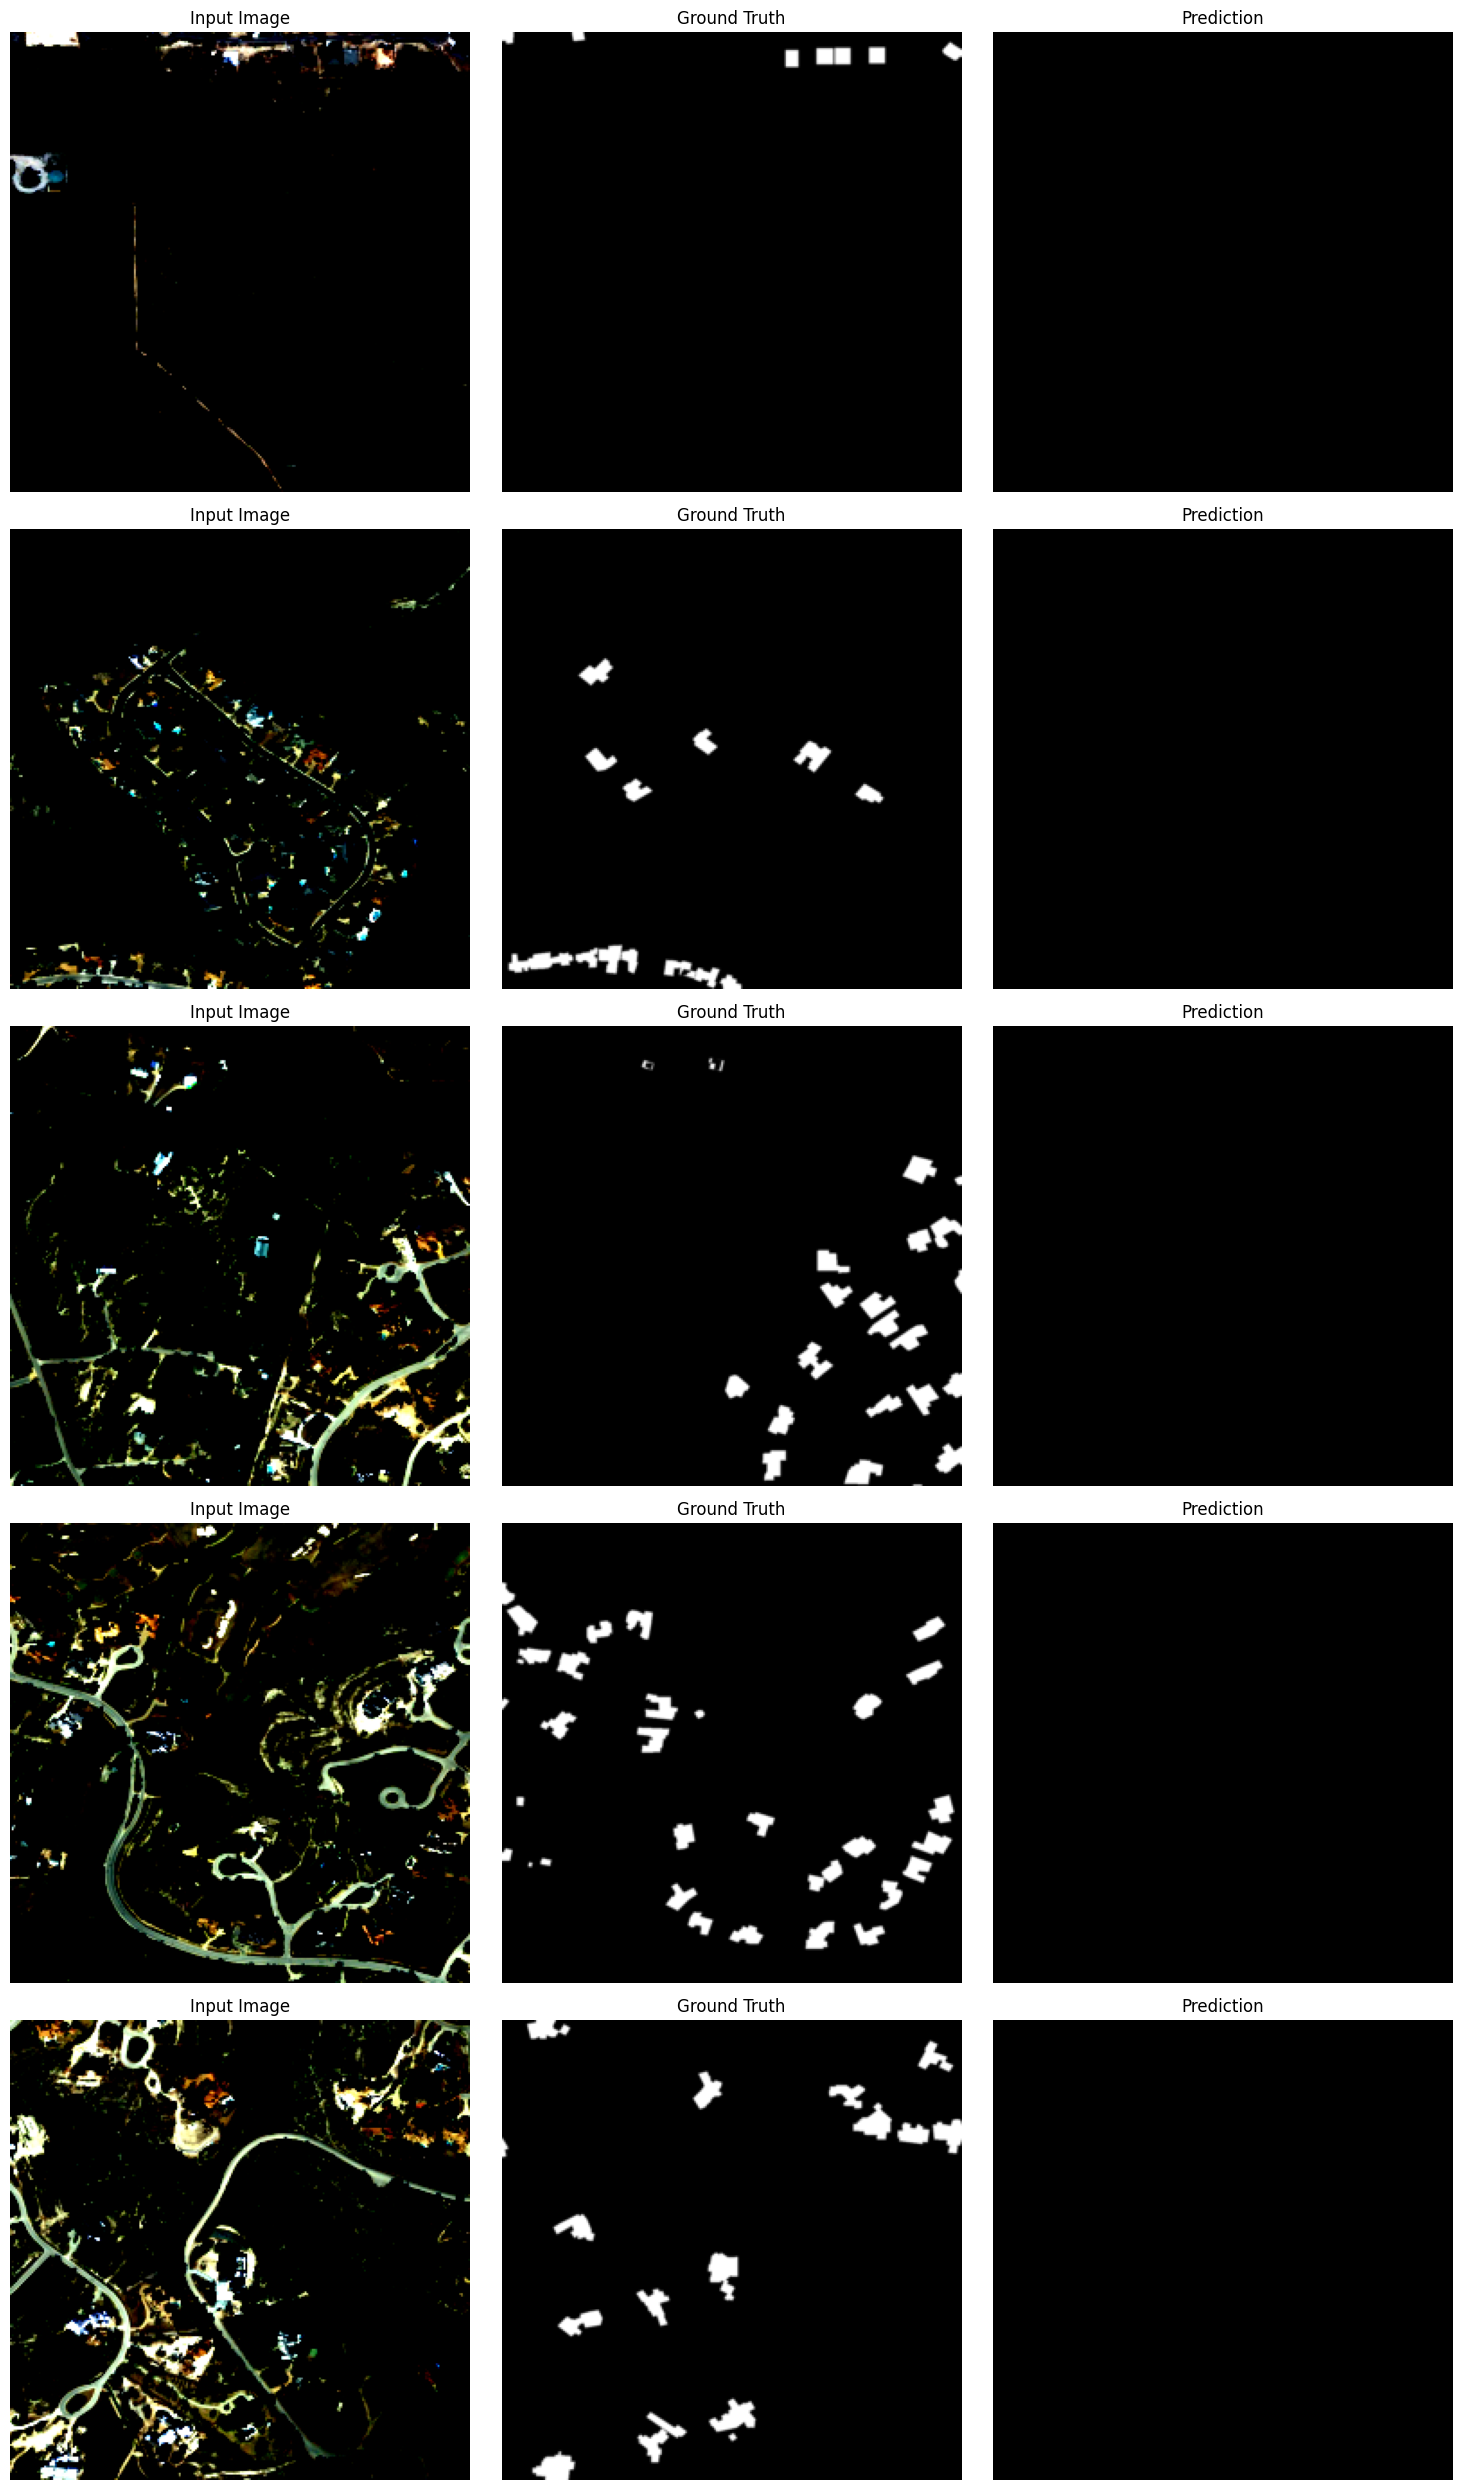

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, device, n_images=5):
    """
    Функция для визуализации предсказаний модели.
    
    model: обученная модель
    dataloader: загрузчик данных (test_loader)
    device: cuda или cpu
    n_images: количество примеров для отображения
    """
    model.eval() # Переводим модель в режим оценки (важно для Dropout/BatchNorm)
    
    # Получаем один батч
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad(): # Отключаем вычисление градиентов для экономии памяти
        outputs = model(images)
        
        # outputs имеет размер [B, 2, H, W]
        # Берем индекс канала с максимальным значением (0 или 1)
        # Это превращает логиты в бинарную маску [B, H, W]
        preds = torch.argmax(outputs, dim=1)
    
    # Переносим данные на CPU и конвертируем в numpy для matplotlib
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()
    
    plt.figure(figsize=(15, n_images * 5))
    
    for i in range(n_images):
        # 1. Исходное изображение
        plt.subplot(n_images, 3, i * 3 + 1)
        # Из формата (C, H, W) в (H, W, C)
        img_to_show = np.transpose(images[i], (1, 2, 0))
        plt.imshow(img_to_show)
        plt.title("Input Image")
        plt.axis("off")
        
        # 2. Реальная маска (Ground Truth)
        plt.subplot(n_images, 3, i * 3 + 2)
        # Маска может иметь размер (1, H, W), убираем лишнюю размерность
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")
        
        # 3. Предсказанная маска
        plt.subplot(n_images, 3, i * 3 + 3)
        plt.imshow(preds[i], cmap='gray')
        plt.title("Prediction")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# --- Запуск визуализации ---
# Используем tst_dl (тестовый загрузчик), который мы создавали ранее
visualize_predictions(model, tst_dl, device, n_images=5)